In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep

import ROOT
import hist

Welcome to JupyROOT 6.24/02


## Caratteristiche del sistema che si sta considerando

Abbiamo uno spettrometro con apertura angolare $\alpha = 60^\circ$, calibrato utilizzando alcuni parametri iniziali. 

In [2]:
α = np.pi/3
_λ_1 = 579.1e-9 ## [nm] Y
_λ_2 = 404.7e-9 ## [nm] P
_θ_0 = 1.5701
_θ_1 = 2.6958
_θ_2 = 2.7904

θ_m3 = 2.6773
θ_m4 = 2.7324
θ_m5 = 2.7651
θ_m6 = 2.7846

Δ_θ = 0.0005
σ_θ = Δ_θ/np.sqrt(3)

In [3]:
def computeAB(th_0, th_1, th_2):
    
    def n_i(th_i, th_0):
        return np.sin((th_i - th_0 + α)/2)/np.sin(α/2)
    A = (n_i(th_1, th_0)*_λ_1**2 - n_i(th_2, th_0)*_λ_2**2)/(_λ_1**2 - _λ_2**2)
    B = (n_i(th_1, th_0) - n_i(th_2, th_0))/(1/(_λ_1**2) - 1/(_λ_2**2))
    return A, B

Text(0.5, 0, '')

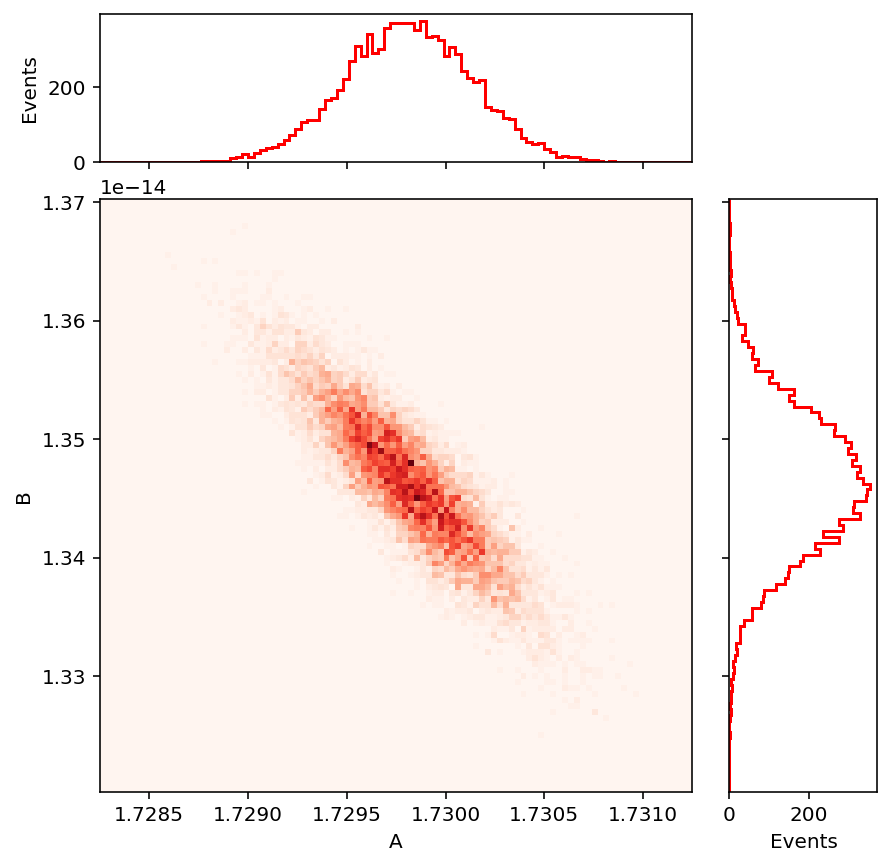

In [17]:
n_samples = 10_000

rnd = ROOT.TRandom3(58347942)

hAB = ROOT.TH2D('', '', 100, 0, 0, 100, 0, 0)
h_AB = hist.Hist(hist.axis.Regular(100, 1.72825, 1.73125, name='A'), hist.axis.Regular(100, 13202.5e-18, 13702.5e-18, name='B'))

for i in range(n_samples):
    A, B = computeAB(th_0=rnd.Gaus(_θ_0,σ_θ), th_1=rnd.Gaus(_θ_1,σ_θ), th_2=rnd.Gaus(_θ_2,σ_θ))
    h_AB.fill(A, B)
    hAB.Fill(A,B)

    
fig = plt.figure(figsize=(6,6))
grid = fig.add_gridspec(2,2, width_ratios=(4, 1), height_ratios=(1, 4), left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)

ax = fig.add_subplot(grid[1,0])
hep.hist2dplot(h_AB, ax=ax, cbar=False, cmap='Reds')

ax_x = fig.add_subplot(grid[0,0], sharex=ax)
ax_y = fig.add_subplot(grid[1,1], sharey=ax)

ax_x.tick_params(axis='x', labelbottom=False)
ax_y.tick_params(axis='y', labelleft=False)

hep.histplot(h_AB.project('A'), yerr=False, ax=ax_x, color='r')
hep.histplot(h_AB.project('B'), yerr=False, ax=ax_y, color='r', orientation='horizontal')

ax_x.set_ylabel('Events')
ax_y.set_xlabel('Events')
ax_x.set_xlabel('')

In [41]:
def over_λ(θ, θ_0, α, A, B):
    return ( 
        ( 
            np.sin( 
                (θ - θ_0 + α)/2 
            )/np.sin(α/2) - A 
        )/B
    )**0.5

θ = np.array([θ_m3, θ_m4, θ_m5, θ_m6])
A = hAB.ProjectionX().GetMean()
B = hAB.ProjectionY().GetMean()
σ_A = hAB.ProjectionX().GetStdDev()
σ_B = hAB.ProjectionY().GetStdDev()

one_over_λ_θ_dep = over_λ(θ, _θ_0, α, A, B)

In [42]:
m = np.array([3, 4, 5, 6])

<ErrorbarContainer object of 3 artists>

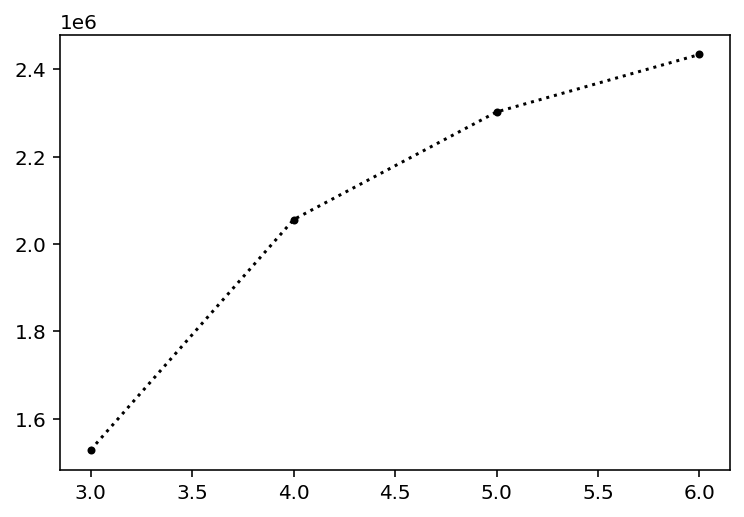

In [43]:
fig, ax = plt.subplots()
ax.errorbar(m, one_over_λ_θ_dep, yerr=np.ones_like(one_over_λ_θ_dep),fmt='k.:')

In [44]:
import iminuit 
from iminuit import cost, Minuit

def model(m, R_H):
    return R_H*(0.25-1/m**2)

c = cost.LeastSquares(m,one_over_λ_θ_dep,yerror=np.ones_like(m),model=model)


In [45]:
m1 = Minuit(c, R_H=1)

In [46]:
m1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.159e+07 (chi2/ndof = 13862594.5)│              Nfcn = 15               │
│ EDM = 2.13e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R_H  │10.9647627e6│0.0000026e6│            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬──────┐
│     │  R_H │
├─────┼──────┤
│ R_H │ 6.76 │
└─────┴──────┘

In [64]:
one_over_λ_θ_dep

array([1528605.02286008, 2055700.14344433, 2302082.46027139,
       2433690.04429333])

In [48]:
ax.plot(c.x, model(c.x, *m1.values), 'r:')

In [132]:
m1.values.to_dict()['R_H'], ' +- ', m1.errors.to_dict()['R_H']

(10964762.661265312, ' +- ', 2.5999991462669767)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x14a76d340>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

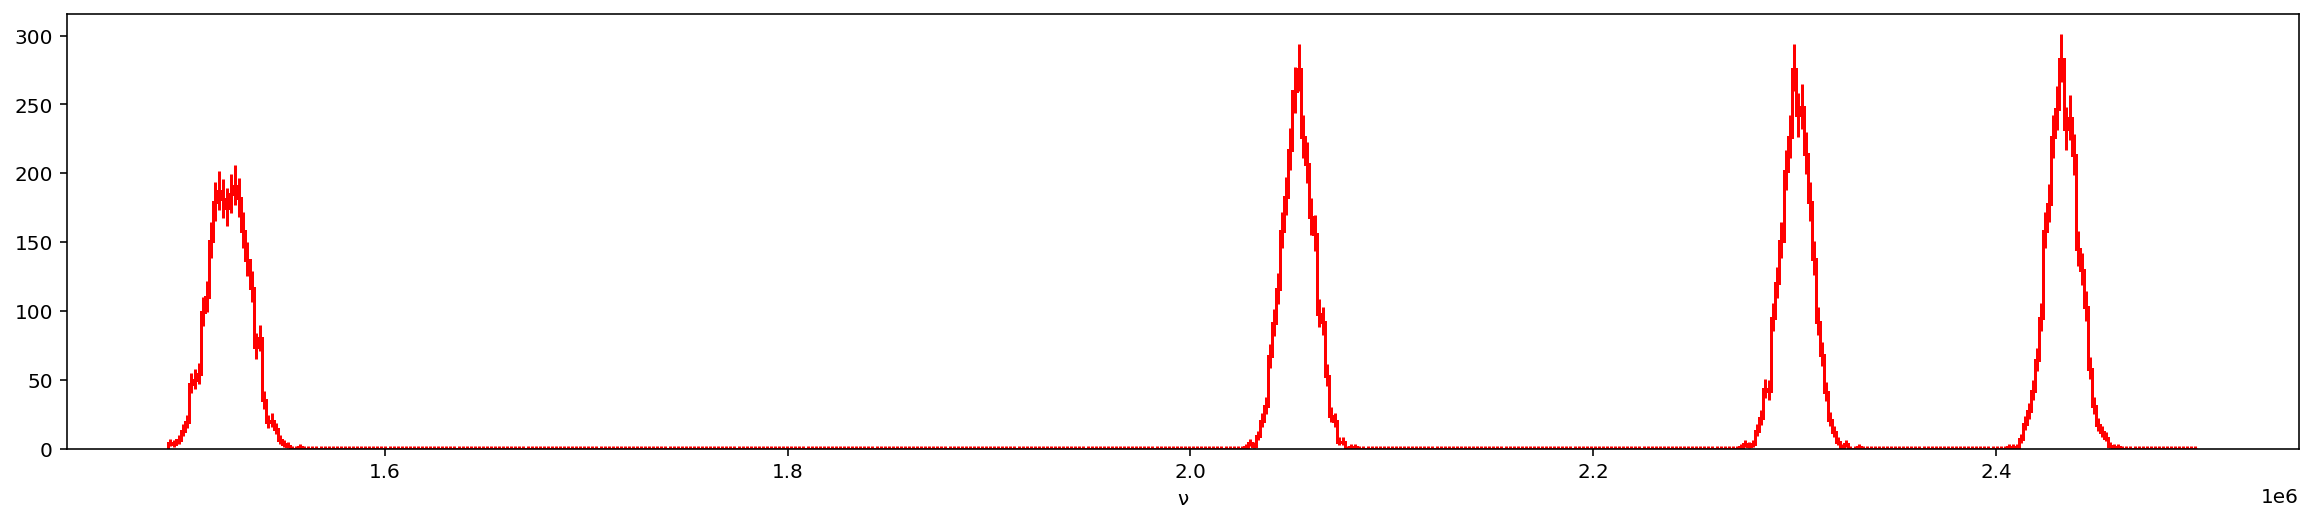

In [130]:
rnd = ROOT.TRandom3(2358972405)

n_samples = 10_000

h_λ = hist.Hist(hist.axis.Regular(500, 1/670e-9, 1/400e-9, name='ν'))

for i in range(n_samples):
    binomial = rnd.Rndm()
    if binomial<=0.25 and binomial>=0:
        h_λ.fill(over_λ(rnd.Gaus(θ_m3, σ_θ), rnd.Gaus(_θ_0, σ_θ), α,  rnd.Gaus(A, σ_A), rnd.Gaus(B, σ_B)))
    elif binomial<=0.5 and binomial>0.25:
        h_λ.fill(over_λ(rnd.Gaus(θ_m4, σ_θ), rnd.Gaus(_θ_0, σ_θ), α,  rnd.Gaus(A, σ_A), rnd.Gaus(B, σ_B)))
    elif binomial<=0.75 and binomial>0.5:
        h_λ.fill(over_λ(rnd.Gaus(θ_m5, σ_θ), rnd.Gaus(_θ_0, σ_θ), α,  rnd.Gaus(A, σ_A), rnd.Gaus(B, σ_B)))
    else:
        h_λ.fill(over_λ(rnd.Gaus(θ_m6, σ_θ), rnd.Gaus(_θ_0, σ_θ), α,  rnd.Gaus(A, σ_A), rnd.Gaus(B, σ_B)))
    
plt.figure(figsize=(20,4))
hep.histplot(h_λ,yerr=None,color='r')

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x145968880>, cbar=<matplotlib.colorbar.Colorbar object at 0x1495e0fa0>, text=[])

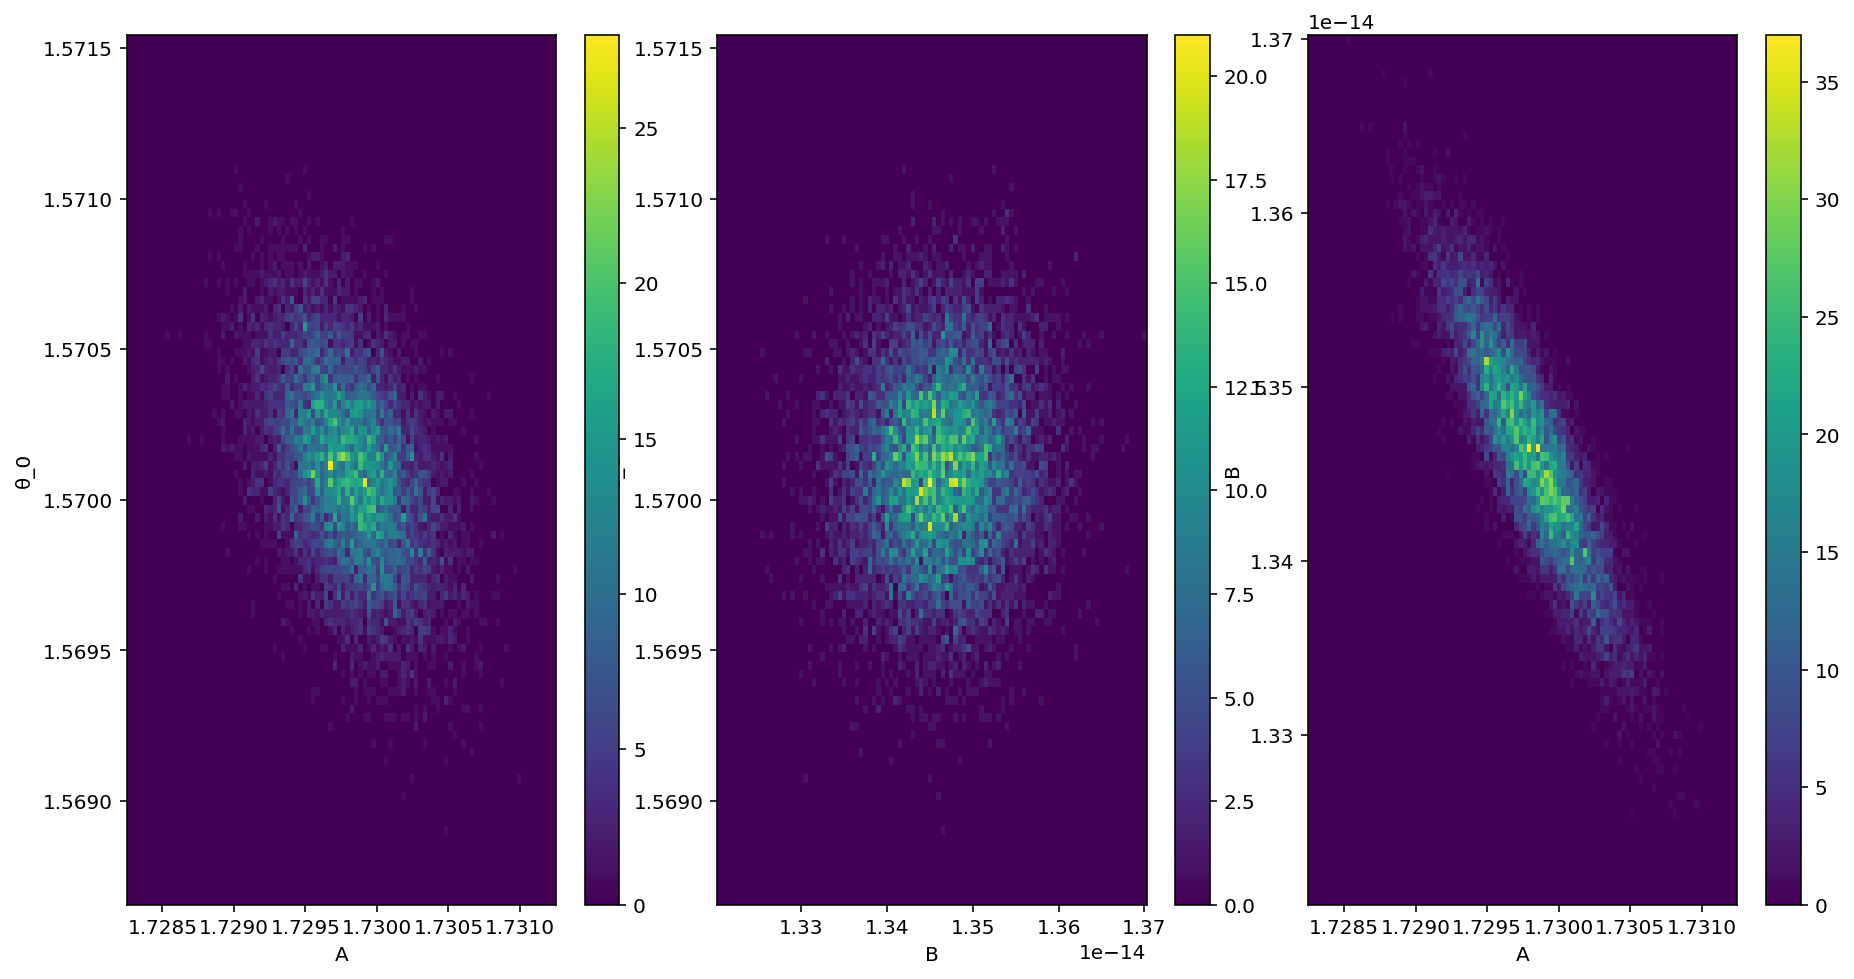

In [97]:
def computeAB(th_0, th_1, th_2):
    
    def n_i(th_i, th_0):
        return np.sin((th_i - th_0 + α)/2)/np.sin(α/2)
    A = (n_i(th_1, th_0)*_λ_1**2 - n_i(th_2, th_0)*_λ_2**2)/(_λ_1**2 - _λ_2**2)
    B = (n_i(th_1, th_0) - n_i(th_2, th_0))/(1/(_λ_1**2) - 1/(_λ_2**2))
    return A, B, # n_i(th_1, th_0), n_i(th_2, th_0), th_1-th_0, th_2-th_0

n_samples = 10_000

rnd = ROOT.TRandom3(246357846)

h_Aθ_0 = hist.Hist(hist.axis.Regular(100, 1.72825, 1.73125, name='A'), hist.axis.Regular(100, _θ_0-5*σ_θ, _θ_0+5*σ_θ, name='θ_0'))
h_Bθ_0 = hist.Hist(hist.axis.Regular(100, 13202.5e-18, 13702.5e-18, name='B'), hist.axis.Regular(100, _θ_0-5*σ_θ, _θ_0+5*σ_θ, name='θ_0'))
h_AB = hist.Hist(hist.axis.Regular(100, 1.72825, 1.73125, name='A'), hist.axis.Regular(100, 13202.5e-18, 13702.5e-18, name='B'))

#h_Aθ_0 = ROOT.TH2D('', '', 100, 0, 0, 100,0,0)
#h_Bθ_0 = ROOT.TH2D('', '', 100, 0, 0, 100,0,0)
#h_AB = ROOT.TH2D('', '', 100, 0, 0, 100,0,0)

for _ in range(n_samples):
    tmp_θ_0 = rnd.Gaus(_θ_0,σ_θ)
    A, B = computeAB(th_0=tmp_θ_0, th_1=rnd.Gaus(_θ_1,σ_θ), th_2=rnd.Gaus(_θ_2,σ_θ))
    h_Aθ_0.fill(A,tmp_θ_0)
    h_Bθ_0.fill(B,tmp_θ_0)
    h_AB.fill(A,B)

fig, (ax1, ax2, ax3) =plt.subplots(1,3, figsize=(15,8))
hep.hist2dplot(h_Aθ_0,ax=ax1)
hep.hist2dplot(h_Bθ_0,ax=ax2)
hep.hist2dplot(h_AB,ax=ax3)

In [129]:
h_AB.axes[0]

Regular(100, 1.72825, 1.73125, name='A')

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


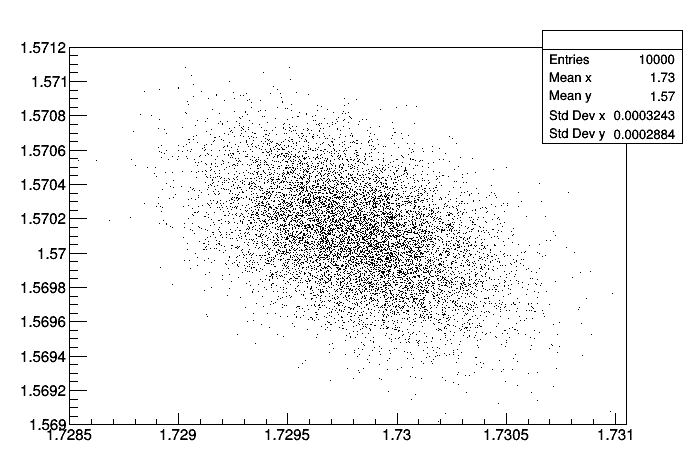

In [95]:
h_Aθ_0.Draw()
ROOT.gROOT.GetListOfCanvases().Draw()

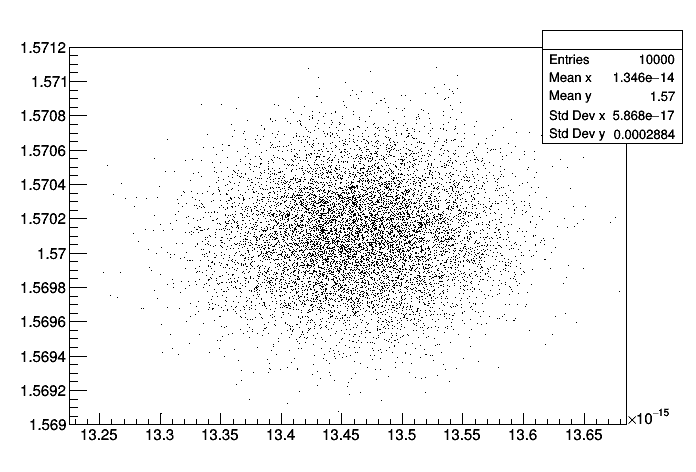

In [96]:
h_Bθ_0.Draw()
ROOT.gROOT.GetListOfCanvases().Draw()

In [ ]:

def one_over_m2(R_H, θ, θ_0, α, A, B):
    return 0.25-